In [27]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm

TRAINDATADIR = "D:/Deep Learning/car-damage-dataset/data1a/training"
TESTDATADIR = "D:/Deep Learning/car-damage-dataset/data1a/validation"
CATEGORIES=os.listdir(TRAINDATADIR)

In [28]:
CATEGORIES

['00-damage', '01-whole']

In [103]:
testing_data = []
TESTDATA = "D:/Deep Learning/car-damage-dataset/data1a/validation/"
CATEGORIES=['00-damage', '01-whole']
IMG_SIZE=300
import os
import cv2
from tqdm import tqdm
def create_testing_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(TESTDATA,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  
                # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                testing_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_testing_data()

print(len(testing_data))

100%|████████████████████████████████████████████████████████████████████████████████| 230/230 [00:04<00:00, 52.82it/s]

460


In [29]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.optimizers import Adam as Adam

In [30]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    TRAINDATADIR,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    TRAINDATADIR,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical',
    subset='validation')

Found 1472 images belonging to 2 classes.
Found 368 images belonging to 2 classes.


In [31]:
test_datagen = ImageDataGenerator(rescale=1./255)

testing_generator = test_datagen.flow_from_directory(
    TESTDATADIR,
    shuffle=True,
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical')

Found 460 images belonging to 2 classes.


## lr = 0.0000001

In [91]:
def build_model():
    model = MobileNet(weights="imagenet", include_top=False, input_shape=(300, 300, 3), pooling='avg')
    for layer in model.layers[:-2]:
        layer.trainable = False
        predictions = Dense(2, activation="softmax")(model.output)
        model_final = Model(inputs=model.input, outputs=predictions)
    return model_final

model_final = build_model()
# compile the model
model_final.compile(loss="categorical_crossentropy", optimizer= Adam(lr = 0.00005), metrics=["accuracy"])

In [92]:
checkpoint = ModelCheckpoint("MobileNet_Car_Classifier.h5", monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False,
                             mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [93]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights

array([1., 1.])

In [94]:
model_final.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 16,
    epochs = 10,
    validation_data=validation_generator,
    validation_steps = validation_generator.samples // 16,
    workers=16,
    callbacks=[checkpoint, early])

Epoch 1/10
23/23 [==============================] - 19s 821ms/step - loss: 0.6311 - acc: 0.6739

Epoch 00001: val_loss improved from inf to 0.63115, saving model to MobileNet_Car_Classifier.h5
92/92 [==============================] - 271s 3s/step - loss: 0.7583 - acc: 0.5856 - val_loss: 0.6311 - val_acc: 0.6739
Epoch 2/10
23/23 [==============================] - 18s 789ms/step - loss: 0.5256 - acc: 0.7473

Epoch 00002: val_loss improved from 0.63115 to 0.52561, saving model to MobileNet_Car_Classifier.h5
92/92 [==============================] - 253s 3s/step - loss: 0.5916 - acc: 0.7072 - val_loss: 0.5256 - val_acc: 0.7473
Epoch 3/10
23/23 [==============================] - 18s 794ms/step - loss: 0.4466 - acc: 0.7935

Epoch 00003: val_loss improved from 0.52561 to 0.44663, saving model to MobileNet_Car_Classifier.h5
92/92 [==============================] - 252s 3s/step - loss: 0.5210 - acc: 0.7446 - val_loss: 0.4466 - val_acc: 0.7935
Epoch 4/10
23/23 [==============================] - 1

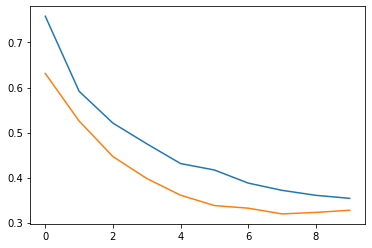

In [95]:
import seaborn as sns
loss=pd.DataFrame(model_final.history.history)
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])

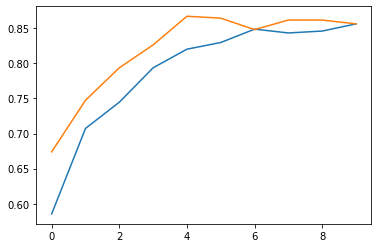

In [96]:
plt.plot(loss['acc'])
plt.plot(loss['val_acc'])

In [104]:
Xtest = []
ytest = []

for features,label in testing_data:
    Xtest.append(features)
    ytest.append(label)
Xtest = np.array(Xtest).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Xtest = Xtest/255.0
ytest=np.array(ytest)

In [105]:
from tensorflow.keras.utils import to_categorical
ytest = to_categorical(ytest,2)

In [106]:
pred=model_final.predict(Xtest)

In [107]:
y_classes = pred.argmax(axis=-1)

In [108]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(ytest.argmax(axis=-1), y_classes))
accuracy_score(ytest.argmax(axis=-1), y_classes)

[[184  46]
 [ 16 214]]


0.8652173913043478

## lr = 0.00001

In [32]:
def build_model():
    model = MobileNet(weights="imagenet", include_top=False, input_shape=(300, 300, 3), pooling='avg')
    for layer in model.layers[:-2]:
        layer.trainable = False
        predictions = Dense(2, activation="softmax")(model.output)
        model_final = Model(inputs=model.input, outputs=predictions)
    return model_final

model_final = build_model()
# compile the model
model_final.compile(loss="categorical_crossentropy", optimizer= Adam(lr = 0.00001), metrics=["accuracy"])

In [33]:
checkpoint = ModelCheckpoint("MobileNet_Car_Classifier.h5", monitor='val_loss', verbose=1, save_best_only=True,
                             save_weights_only=False,
                             mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [10]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)
class_weights

array([1., 1.])

In [34]:
model_final.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 16,
    epochs = 10,
    validation_data=validation_generator,
    validation_steps = validation_generator.samples // 16,
    workers=16,
    callbacks=[checkpoint, early])

Epoch 1/10
23/23 [==============================] - 18s 800ms/step - loss: 0.6422 - acc: 0.6630

Epoch 00001: val_loss improved from inf to 0.64221, saving model to MobileNet_Car_Classifier.h5
92/92 [==============================] - 268s 3s/step - loss: 0.6586 - acc: 0.6202 - val_loss: 0.6422 - val_acc: 0.6630
Epoch 2/10
23/23 [==============================] - 17s 757ms/step - loss: 0.6180 - acc: 0.6712

Epoch 00002: val_loss improved from 0.64221 to 0.61802, saving model to MobileNet_Car_Classifier.h5
92/92 [==============================] - 244s 3s/step - loss: 0.6123 - acc: 0.6726 - val_loss: 0.6180 - val_acc: 0.6712
Epoch 3/10
23/23 [==============================] - 36s 2s/step - loss: 0.6007 - acc: 0.6875

Epoch 00003: val_loss improved from 0.61802 to 0.60066, saving model to MobileNet_Car_Classifier.h5
92/92 [==============================] - 485s 5s/step - loss: 0.5994 - acc: 0.6929 - val_loss: 0.6007 - val_acc: 0.6875
Epoch 4/10
23/23 [==============================] - 37s 

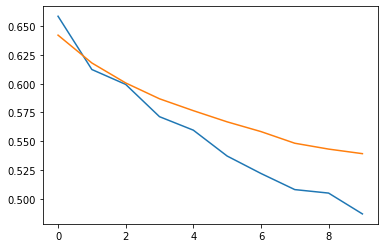

In [35]:
import seaborn as sns
loss=pd.DataFrame(model_final.history.history)
plt.plot(loss['loss'])
plt.plot(loss['val_loss'])

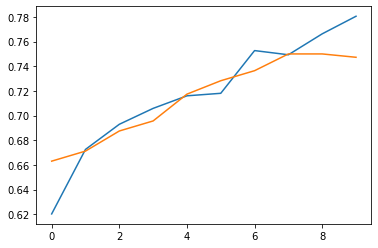

In [36]:
plt.plot(loss['acc'])
plt.plot(loss['val_acc'])

In [67]:
Xtest = []
ytest = []

for features,label in testing_data:
    Xtest.append(features)
    ytest.append(label)

Xtest = np.array(Xtest).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Xtest = Xtest/255.0
ytest=np.array(ytest)

[[[[240]
   [241]
   [239]
   ...
   [201]
   [197]
   [202]]

  [[193]
   [189]
   [193]
   ...
   [ 48]
   [ 78]
   [ 73]]

  [[ 62]
   [ 87]
   [ 83]
   ...
   [225]
   [219]
   [220]]

  ...

  [[154]
   [171]
   [170]
   ...
   [110]
   [115]
   [112]]

  [[ 82]
   [ 88]
   [ 86]
   ...
   [144]
   [114]
   [110]]

  [[167]
   [138]
   [134]
   ...
   [ 85]
   [128]
   [119]]]


 [[[149]
   [165]
   [165]
   ...
   [ 85]
   [ 85]
   [ 82]]

  [[ 86]
   [ 86]
   [ 84]
   ...
   [114]
   [ 83]
   [ 80]]

  [[ 85]
   [ 54]
   [ 51]
   ...
   [ 95]
   [131]
   [124]]

  ...

  [[140]
   [152]
   [158]
   ...
   [  4]
   [  4]
   [  4]]

  [[  3]
   [  3]
   [  3]
   ...
   [ 65]
   [ 65]
   [ 65]]

  [[ 73]
   [ 73]
   [ 73]
   ...
   [194]
   [173]
   [171]]]


 [[[126]
   [138]
   [144]
   ...
   [ 10]
   [ 10]
   [ 10]]

  [[  9]
   [  9]
   [  9]
   ...
   [ 61]
   [ 61]
   [ 61]]

  [[ 62]
   [ 62]
   [ 62]
   ...
   [191]
   [171]
   [169]]

  ...

  [[ 63]
   [ 85]
   [ 96]
   

In [68]:
from tensorflow.keras.utils import to_categorical
ytest = to_categorical(ytest,2)

In [69]:
Xtest = Xtest/255.0

In [70]:
pred=model_final.predict(Xtest)

In [74]:
y_classes = pred.argmax(axis=-1)

In [79]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(ytest.argmax(axis=-1), y_classes))
accuracy_score(ytest.argmax(axis=-1), y_classes)

[[157  73]
 [ 21 209]]


0.7956521739130434